In [1]:
import torch
from torchvision.models import resnet50
import torchvision.transforms as transforms
from utils import dataloader
from matplotlib import pyplot as plt
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

from attacks.zoo_attack import zoo_attack
from attacks.boundary_attack import boundary_attack
from attacks.blackbox_attack import opt_attack

In [2]:
with open('data/imagenet_labels.txt') as f:
    labels = f.readlines()

In [3]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [4]:
# Models
model = resnet50(pretrained=True)

last_cnn_layer = [model.layer4[-1]]

num_images = 1

# Datasets
train_loader, _ = dataloader(dataset_name='imagenet', train_size=2000, test_size=2000, 
                            data_dir='./data/imagenet_val', batch_size=1, device=device)

# Type of attacks
# adversarial, pertub, image, label, orig_scores, adv_scores = zoo_attack(model, train_loader, num_samples=num_images)
# adversarial, pertub, image, label, orig_scores, adv_scores = boundary_attack(model, train_loader, num_samples=num_images)
adversarial, pertub, image, label, orig_scores, adv_scores = opt_attack(model, train_loader, num_samples=num_images)

Running on first 1 images 
======== Image 0 =========
Original label:  tensor([863], device='cuda:0')
Predicted label:  tensor([863], device='cuda:0')
Searching for the initial direction on 1000 samples: 
Crossed patience, breaking execution
--------> Found distortion 201.7089
Crossed patience, breaking execution
--------> Found distortion 189.8289
--------> Found distortion 127.8261
--------> Found distortion 121.3196
--------> Found distortion 118.1840
--------> Found distortion 112.3832
--------> Found distortion 100.5065
--------> Found distortion 98.8812
--------> Found distortion 87.2456
--------> Found distortion 75.3957
==========> Found best distortion 75.3957 in 49.3961 seconds using 2383 queries
Iteration  50: g(theta + beta*u) = 17.6957 g(theta) = 17.6914 distortion 17.6914 num_queries 9716
Iteration 100: g(theta + beta*u) = 11.5505 g(theta) = 11.5513 distortion 11.5513 num_queries 19436

Adversarial Example Found Successfully: distortion 11.5463 target 866 queries 21854 
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


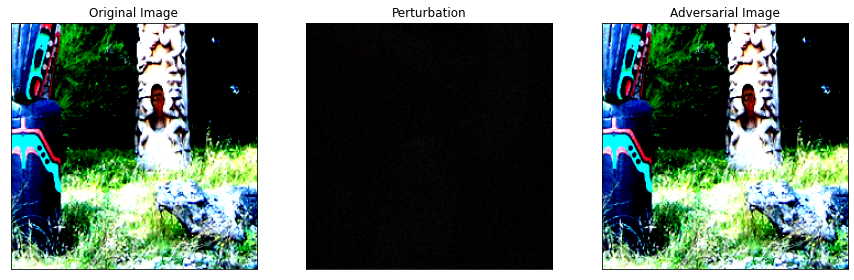

In [5]:
fig, axs = plt.subplots(1,3, figsize=(15,15))


axs[0].imshow(image.detach().cpu().numpy()[0].transpose(1,2,0))
axs[1].imshow(pertub.detach().cpu().numpy()[0].transpose(1,2,0))
axs[2].imshow(adversarial.detach().cpu().numpy()[0].transpose(1,2,0))

# For zoo-attack
# axs[0].imshow(image[0].transpose(1,2,0))
# axs[1].imshow(pertub[0][0].transpose(1,2,0))
# axs[2].imshow(adversarial[0].transpose(1,2,0))

axs[0].title.set_text('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].title.set_text('Perturbation')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].title.set_text('Adversarial Image')
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.savefig('plots/opt-attack.png', dpi=300)

plt.show()

In [6]:
topk_labels = []
topk_probs = []

probabilities = torch.softmax(orig_scores[0], dim=0)
top_probabilities = torch.topk(probabilities, 5)

# top_probabilities = torch.topk(torch.Tensor(orig_scores)[0], 5) # For zoo-attack

for i, idx in enumerate(top_probabilities.indices):
    print(f'{labels[idx].rstrip()} - {top_probabilities.values[i] * 100 : .1f}%')
    topk_labels.append(labels[idx].rstrip())
    topk_probs.append(round(top_probabilities.values[i].item()*100, 3))

totem pole -  94.8%
freight car -  0.7%
book jacket -  0.5%
tank -  0.4%
zebra -  0.3%


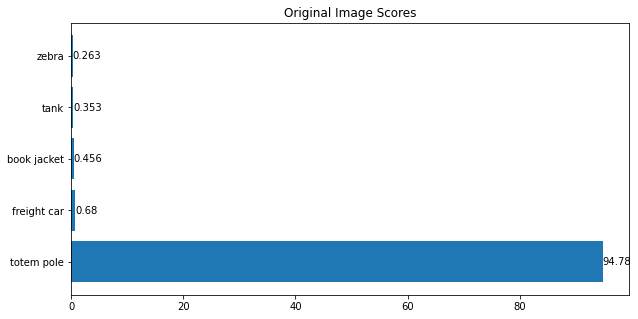

In [7]:
fig = plt.figure(figsize=(10, 5))

bars = plt.barh(topk_labels, topk_probs)
plt.bar_label(bars)
plt.title('Original Image Scores')
plt.savefig('plots/opt-attack-orig_scores.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [8]:
topk_labels = []
topk_probs = []

probabilities = torch.softmax(adv_scores[0], dim=0)
top_probabilities = torch.topk(probabilities, 5)

# top_probabilities = torch.topk(torch.Tensor(adv_scores)[0], 5) For zoo-attack

for i, idx in enumerate(top_probabilities.indices):
    print(f'{labels[idx].rstrip()} - {top_probabilities.values[i] * 100 : .1f}%')
    topk_labels.append(labels[idx].rstrip())
    topk_probs.append(round(top_probabilities.values[i].item()*100, 3))

tractor -  23.3%
totem pole -  23.3%
harvester -  7.6%
tank -  5.6%
freight car -  5.2%


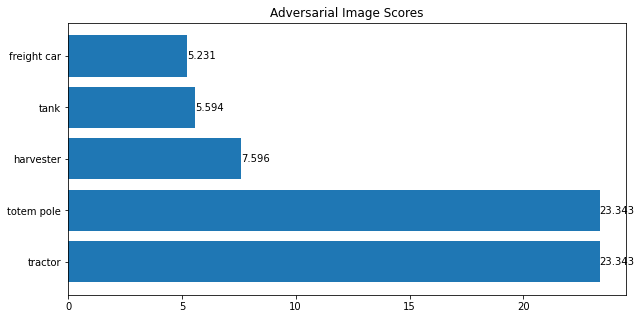

In [9]:
fig = plt.figure(figsize=(10, 5))

bars = plt.barh(topk_labels, topk_probs)
plt.bar_label(bars)
plt.title('Adversarial Image Scores')
plt.savefig('plots/opt-attack-adv_scores.png', dpi=300, bbox_inches = 'tight')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


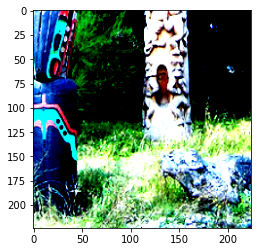

In [10]:
img = image.detach().cpu().numpy()[0].transpose(1,2,0)
# img = image[0].transpose(1,2,0) # For zoo-attack
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


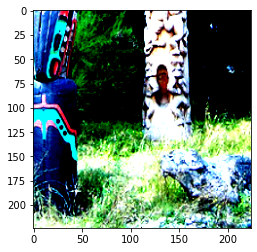

In [11]:
adv = adversarial.detach().cpu().numpy()[0].transpose(1,2,0)
# adv = adversarial[0].transpose(1,2,0) # For zoo-attack
plt.imshow(adv)

In [12]:
model.to('cpu')
model.eval()

last_cnn_layer = [model.layer4[-1]]

In [14]:
# PIL_image = Image.fromarray(img.astype('uint8'), 'RGB') # original image

PIL_image = Image.fromarray(adv.astype('uint8'), 'RGB') # adversarial image

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
]
)

transform_without_normalize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
]
)

cam = GradCAM(model=model, target_layers=last_cnn_layer, use_cuda=False)


tensor = transform(PIL_image)
input_batch = tensor.unsqueeze(0)

# targets = [ClassifierOutputTarget(745)] # For zoo-attack
targets = [ClassifierOutputTarget(863)]
grayscale_cam = cam(input_tensor=input_batch, targets=targets)
grayscale_cam = grayscale_cam[0, :]
rgb_image = transform_without_normalize(PIL_image).transpose(0, 1).transpose(1,2).numpy()
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

viz = Image.fromarray(visualization, 'RGB')

# viz.save('plots/opt-attack-orig_image.png')
viz.save('plots/opt-attack-adv_image.png')